<h1>
<center>Empirical Asset Pricing via Machine Learning</center>
</h1>



<center>Alexander Margetis, Lanya Ma, Sheng Yang, Yiming Tan</center>



## 1. Introduction



In this project, we conducted an empirical analysis of machine learning methods in asset pricing. We aim to measure and predict risk premium with bundles of underlying factors. In particular, we attempt to study the structure of cross-sectional returns by using various factors. These factors can be stock-level firm characteristics, macroeconomic descriptors and many other derived indicators. In the empirical literature, classical models are proposed to estimate and explain the risk premia with several factors, like CAPM, Fama-French 3 factor and later Fama-French 5 factor model. These models are basically linear projection from bahavior of stocks' expected returns to multiple variates. As the high-dimensional nature is innate in machine learning methods, we can enhances the flexibility of representing assets risk profile relative to more traditional econometric prediction techniques.And the functionals which project high-dimensional predictors to risk premia can be complicated. That's why the application of machine learning in this field can be rather attractive.   

Our major contributions in this project are three-fold. First, we investigate machine learning techniques in prediction of cross-sectional returns. This tells us whether machine learning algorithms can improve the estimation of out-of-sample expected returns. Second, we examine the feature importance of factors.This process gives us insights that how to select informative factors. Third, we study the stability of machine learning in portfolio constrcution. We analyze the performance of long-short portfolio from the algorithms over the horizon.

## 2. Methodology

### 2.1 Data Preprocessing and Exploratory Data Analysis

Data Cleaning (Lanya Ma)

In [3]:
import pandas as pd
import os
import glob

os.chdir('/Users/shengyang/Documents/CFRM/521 Machine Learning for Finance/CFRM521Project/data')
result = glob.glob('*.csv')
print(result)
data_name_list = list(map(lambda x: x[:-4] , result))

['current.csv', 'sales_growth1yr.csv', 'debt_over_asset.csv', 'netprofit_margin.csv', 'market_cap.csv', 'roic.csv', 'roa.csv', 'price.csv', 'GICS_code.csv', 'ocf_ps.csv', 'turnover.csv', 'tax_to_ebt.csv', 'roe.csv', 'pb.csv', 'ebitda_to_sales.csv', 'ca_to_assets.csv', 'bps.csv', 'op_to_debt.csv', 'ps_ttm.csv', '3m_tbill_rate.csv', 'ocf_to_sales.csv', 'eps_ttm.csv', 'pe_ttm.csv', 'ocf_to_debt.csv', 'equity_to_totalcap.csv']


In [4]:
import copy
import numpy as np

def transform_row(filename):
    raw_df = pd.read_csv(filename)
    row_names = raw_df.iloc[:,0]
    raw_df = raw_df.rename(index = row_names)
    new_df = raw_df.drop(raw_df.columns[0],axis = 1)
    return new_df

#Omit stocks w/ no price
price = transform_row('price.csv')
valid = []
nrow = price.shape[0]
ncol = price.shape[1]
price_mat = np.asmatrix(price)
for i in range(0,nrow):
    count = 0
    for j in range(0,ncol):
        if price_mat[i,j] == 0:
            count = count+0
        else:
            count = count+1
    if count != 0:
        valid.append(i)

price_v = price.iloc[valid,:]
is_available = copy.deepcopy(price_v)
is_available[:] = np.nan
is_available[price_v != 0] = 1
price_df = price_v*is_available


def tranfrom_missing(filename):
    raw =  transform_row(filename)
    raw = raw.iloc[valid,:]
    nrow = raw.shape[0]
    ncol = raw.shape[1]
    raw = raw.applymap(lambda x: float(x))
    raw_mat = np.asmatrix(raw)
    for i in range(0,nrow):
        fill_data = 0
        for j in range(0,ncol):
            if raw_mat[i,j] != 0:
                fill_data = raw_mat[i,j]
            else:
                raw_mat[i,j] = fill_data
    filled_df = pd.DataFrame(raw_mat)
    filled_df.index = price_v.index.values
    filled_df.columns = price_v.columns.values
    filled_df = np.multiply(filled_df,is_available)
    filled_df[filled_df == 0] = np.nan
    return filled_df


sector_code = transform_row('GICS_code.csv')
sector_code[sector_code ==0] = np.nan
g_code = sector_code.iloc[:,0].values.reshape(-1, 1)
gics_code = g_code[valid]

In [5]:
features_dict = {}
for idx, element in enumerate(result):
    feature_name = data_name_list[idx]
    if feature_name not in ['3m_tbill_rate','GICS_code','price']:
        feature_df = tranfrom_missing(element)
        features_dict[data_name_list[idx]] = feature_df

In [6]:
#Stock return
price_df.head()
r_m = copy.deepcopy(price_df)
r_m[:] = np.nan

nrow = r_m.shape[0]
ncol = r_m.shape[1]
r_mat = np.asmatrix(r_m)
p_mat = np.asmatrix(price_df)
for i in range(0,nrow):
    for j in range(0,ncol-1):
        if np.isnan(p_mat[i,j+1]) or np.isnan(p_mat[i,j]):
            r_mat[i,j] = np.nan
        else:
            r_mat[i,j] = (p_mat[i,j+1]-p_mat[i,j])/p_mat[i,j]
return_mon = pd.DataFrame(r_mat)
return_mon.index = price_v.index.values
return_mon.columns = price_v.columns.values

#Risk free rate
rf= transform_row('3m_tbill_rate.csv')
rfree = rf.loc[return_mon.columns]/12

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [7]:
#Raw Data Dictionary
data_dict = {}
time_keys = price.columns.values
first_feature = list(features_dict.keys())[0]
for time_key in time_keys[:-1]:
    cat_array = features_dict[first_feature][time_key].values.reshape(-1, 1)
    for key in list(features_dict.keys())[1:]:
        right_array = features_dict[key][time_key].values.reshape(-1, 1)
        cat_array = np.concatenate((cat_array,right_array),axis = 1)
    if np.isnan(rfree.loc[time_key].values):
        rfree.loc[time_key] = 0
    y_array = return_mon[time_key].values.reshape(-1,1)-rfree.loc[time_key].values.reshape(-1,1)
    cat_array = np.concatenate((cat_array,gics_code),axis = 1)
    data_array = np.concatenate((cat_array,y_array),axis = 1)
    data_df = pd.DataFrame(data_array)
    data_df.index = price_df.index.values
    data_df.columns = list(features_dict.keys()) + ['GICS_code'] + ['Excess_return']
    data_dict[time_key] = data_df

In [8]:
import pickle
with open('factordata.p', 'wb') as fp:
    pickle.dump(data_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open('factordata.p', 'rb') as fp:
    factordata = pickle.load(fp)

In [13]:
import sklearn, numpy, scipy
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The numpy version is {}.'.format(numpy.__version__))
print('The scipy version is {}.'.format(scipy.__version__))

The scikit-learn version is 0.21.2.
The numpy version is 1.16.4.
The scipy version is 1.3.0.


In [11]:
#Construct Pipeline
def valid_return(dataframe):
    exist=[]
    nrow = data_df.shape[0]
    for i in range(0,nrow):
        if not np.isnan(dataframe['Excess_return'][i]):
            exist.append(i)
    dat = dataframe.iloc[exist,:]
    return dat

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import Imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
import sys
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

num_pipeline = Pipeline([
        ('imp', IterativeImputer(max_iter=10, random_state=0,estimator = KNeighborsRegressor(n_neighbors=15))),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('imputer', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
        ('one', OneHotEncoder()),
    ])


X = {}
y = {}

In [12]:
for time_key in time_keys[:-1]:
    dat = valid_return(data_dict[time_key])
    X_raw = dat.drop('Excess_return', axis=1)
    num_features = X_raw.drop('GICS_code', axis=1)
    num_attribs = list(num_features)
    cat_attribs = ["GICS_code"]
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])
    X_array = full_pipeline.fit_transform(dat)
    y_array = dat['Excess_return'].values
    X[time_key] = pd.DataFrame(X_array)
    y[time_key] = pd.DataFrame(y_array)
    y[time_key].columns = ['Excess_return']
    y[time_key].index = dat.index.values
    X[time_key].index = dat.index.values

In [14]:
Train = {}
Test = {}
for time_key in time_keys[:100]:
    Train[time_key] = pd.concat([X[time_key],y[time_key]],axis=1)
for time_key in time_keys[100:-1]:
    Test[time_key] = pd.concat([X[time_key],y[time_key]],axis=1)

In [15]:
import pickle
with open('cleanTrain.p', 'wb') as gp:
    pickle.dump(Train, gp, protocol=pickle.HIGHEST_PROTOCOL)
with open('cleanTest.p', 'wb') as hp:
    pickle.dump(Test, hp, protocol=pickle.HIGHEST_PROTOCOL)

### 2.2 Generalized linear models


### 2.3 Support vector machines 


### 2.4 Ensemble Learning (by Sheng Yang)

We applied the features (e.g. 0-46) of the current month to predict the excessive return of next month. Append the excessive return of next month to the features of the current month. 

### 2.4.1 Data preparation

In [16]:
data=pd.DataFrame()
for i in range(123):
    time_key= time_keys[i]
    next_time_key= time_keys[i+1]
    if i<100:
        tmp0=Train[time_key]
        if i==99:
            tmp1=Test[next_time_key]
        else:
            tmp1=Train[next_time_key]
        tmp0['Next_Excess_return']=tmp1.loc[list(tmp0.index),'Excess_return']
        tmp0['time']=time_key
        data=pd.concat([data, tmp0])
    else:
        tmp0=Test[time_key]
        tmp1=Test[next_time_key]
        tmp0['Next_Excess_return']=tmp1.loc[list(tmp0.index),'Excess_return']
        tmp0['time']=time_key
        data=pd.concat([data, tmp0])

In [17]:
data=data.drop([47], axis=1)
data=data.dropna()

In [18]:
train_full_row=0
for i in range(100):
    time_key= time_keys[i]
    # print(i, X[time_key].shape)
    train_full_row=train_full_row + X[time_key].shape[0]
    
train_full= data.head(train_full_row)
test = data.iloc[train_full_row:-1,]

We create stratified training and validation set bases on time.

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,
                               test_size=0.3, random_state=42)

X_train_full= train_full[range(47)]
y_train_full= train_full['Next_Excess_return']
X_test= test[range(47)]
y_test= test['Next_Excess_return']
for train_idx, valid_idx in split.split(train_full, train_full['time']):
    train_set= train_full.iloc[train_idx]
    valid_set= train_full.iloc[valid_idx]

X_train= train_set[range(47)]
X_valid= valid_set[range(47)]
y_train= train_set['Next_Excess_return']
y_valid= valid_set['Next_Excess_return']

### 2.4.2 Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(bootstrap=True, n_estimators=100, n_jobs=-1,
                                max_features=7, random_state=42)
rf_reg.fit(X_train_full, y_train_full)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [59]:
# test MSE
print(mean_squared_error(y_test, rf_reg.predict(X_test)))
# test MAE
print(mean_absolute_error(y_test, rf_reg.predict(X_test))) 


0.24015550754719495
0.18914401251129367


Grid search for best hyperparameters in random forest:

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 50 (2×5×5) combinations of hyperparameters
    {'bootstrap': [False, True], 'n_estimators': [10, 50, 100, 200, 500], 'max_features': [3, 6, 12, 24, 47]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of 18*5=90 rounds of training 
forest_reg_grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           n_jobs=-1)

forest_reg_grid_search.fit(X_train.head(20000), y_train.head(20000))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'bootstrap': [False, True],
      

In [34]:
forest_reg_grid_search.best_params_

{'bootstrap': True, 'max_features': 6, 'n_estimators': 200}

In [35]:
forest_reg_grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [36]:
best_rf_reg= forest_reg_grid_search.best_estimator_

In [37]:
best_rf_reg.fit(X_train_full, y_train_full)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Performance of random forest method with best hyperparameters:
<br>The random forest has test MSE as 0.22069, and MAE as 0.17614.

In [60]:
# test MSE
print(mean_squared_error(y_test, best_rf_reg.predict(X_test)))
# test MAE
print(mean_absolute_error(y_test, best_rf_reg.predict(X_test))) 

0.2206928007413852
0.17613702524522853


### 2.4.3 Extra Trees

Performance of extra trees method with best hyperparameters:
<br>The extra trees has test MSE as 0.21223, and MAE as 0.16141.

In [51]:
from sklearn.ensemble import ExtraTreesRegressor

extratrees = ExtraTreesRegressor(bootstrap=True, n_estimators=200, max_features=7,
                                  n_jobs=-1, random_state=42)

In [52]:
extratrees.fit(X_train_full, y_train_full)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
                    max_features=7, max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                    oob_score=False, random_state=42, verbose=0,
                    warm_start=False)

In [61]:
# test MSE
print(mean_squared_error(y_test, extratrees.predict(X_test)))
# test MAE
print(mean_absolute_error(y_test, extratrees.predict(X_test))) 

0.21222847676059375
0.16140953205835543


### 2.4.4 Adaboost


Performance of Adaboost method:
<br>The Adaboost has test MSE as 0.21522, and MAE as 0.17949.

In [55]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(n_estimators=50,
                         learning_rate=0.25, random_state=42)

In [57]:
ada.fit(X_train_full, y_train_full)

AdaBoostRegressor(base_estimator=None, learning_rate=0.25, loss='linear',
                  n_estimators=50, random_state=42)

In [62]:
# test MSE
print(mean_squared_error(y_test, ada.predict(X_test)))
# test MAE
print(mean_absolute_error(y_test, ada.predict(X_test))) 

0.21522228677855376
0.179486893265396


### 2.4.5 Gradient Boosting

Performance of Gradient Boosting method:
<br>The Gradient Boosting has test MSE as 0.22502, and MAE as 0.16838.

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(max_depth=3,
                                n_estimators=100,
                                learning_rate=0.1,
                                random_state=42)

In [65]:
gb.fit(X_train_full, y_train_full)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [66]:
# test MSE
print(mean_squared_error(y_test, gb.predict(X_test)))
# test MAE
print(mean_absolute_error(y_test, gb.predict(X_test))) 

0.22502005853900364
0.16838315044279983


### 2.4.6 Xgboost

Performance of Xgboost method:
<br>The Xgboost has test MSE as 0.21397, and MAE as 0.17564.

In [69]:
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=42)

In [72]:
xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=10)

[21:10:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.969394
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.949863
[2]	validation_0-rmse:0.933756
[3]	validation_0-rmse:0.920528
[4]	validation_0-rmse:0.909663
[5]	validation_0-rmse:0.900771
[6]	validation_0-rmse:0.893523
[7]	validation_0-rmse:0.887614
[8]	validation_0-rmse:0.882807
[9]	validation_0-rmse:0.878888
[10]	validation_0-rmse:0.875695
[11]	validation_0-rmse:0.873195
[12]	validation_0-rmse:0.871095
[13]	validation_0-rmse:0.869508
[14]	validation_0-rmse:0.86811
[15]	validation_0-rmse:0.867017
[16]	validation_0-rmse:0.866448
[17]	validation_0-rmse:0.865716
[18]	validation_0-rmse:0.865164
[19]	validation_0-rmse:0.864677
[20]	validation_0-rmse:0.864279
[21]	validation_0-rmse:0.863995
[22]	validation_0-rmse:0.863735
[23]	validation_0-rmse:0.863517
[24]	validation_0-rmse:0.863335
[25]	validation_0-rmse:0.86365

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [73]:
# test MSE
print(mean_squared_error(y_test, xgb.predict(X_test)))
# test MAE
print(mean_absolute_error(y_test, xgb.predict(X_test)))

0.2139683980601173
0.17564382804570586


### 2.4.7 Stacking Ensemble Method

Stacking ensemble method: Use the predictions from random forest, extra trees, Adaboost, Gradient boosting
<br> as features and the actual label of the observations as the target. 

In [76]:
from sklearn.model_selection import cross_val_predict

models = [best_rf_reg, extratrees, ada, gb]
model_names = ["forest", "ExtraTrees", "AdaBoost", "GradientBoost"]

In [78]:
pred = []
for idx, m_ in enumerate(models):
    pred.append(cross_val_predict(m_, X_train_full, y_train_full,
                                  cv=3, n_jobs=-1))
    print(model_names[idx])
pred=np.transpose(np.array(pred))

forest
ExtraTrees
AdaBoost
GradientBoost


In [80]:
blender = RandomForestRegressor(n_estimators=100,
                                 n_jobs=-1, random_state=42)

%time blender.fit(pred, y_train_full)

CPU times: user 7min 26s, sys: 2.93 s, total: 7min 29s
Wall time: 58.7 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [82]:
pred_test = []
for idx, m_ in enumerate(models):
    pred_test.append(m_.predict(X_test))
    print(model_names[idx])
pred_test = np.transpose(np.array(pred_test))

forest
ExtraTrees
AdaBoost
GradientBoost


Performance of stacking ensemble method:
<br>The stacking ensemble has test MSE as 0.30025, and MAE as 0.29806.

In [83]:
# test MSE
print(mean_squared_error(y_test, blender.predict(pred_test)))
# test MAE
print(mean_absolute_error(y_test, blender.predict(pred_test)))

0.3002464165646861
0.29806191206527116


### 2.4.8 Variable importance of different tree methods:

In [150]:
models = [best_rf_reg, extratrees, ada, gb, xgb]
model_names = ["random forest", "ExtraTrees", "AdaBoost", "GradientBoost", "Xgboost"]

importances = []
for idx, m_ in enumerate(models):
    importances.append(m_.feature_importances_)
    print(model_names[idx])
importances = np.transpose(np.array(importances))


random forest
ExtraTrees
AdaBoost
GradientBoost
Xgboost


In [151]:
importances=pd.DataFrame(importances, columns=model_names)
importances

,random forest,ExtraTrees,AdaBoost,GradientBoost,Xgboost
0,0.077215,0.056119,0.000000e+00,0.057011,0.036187
1,0.101904,0.060023,1.019207e-01,0.253035,0.046038
2,0.037222,0.047713,9.163462e-05,0.010306,0.081690
3,0.044125,0.046616,0.000000e+00,0.002769,0.006266
4,0.038668,0.042184,1.938611e-04,0.001729,0.008348
5,0.053057,0.049622,3.798762e-09,0.016046,0.003438
6,0.042437,0.030721,9.014996e-05,0.023595,0.011486
7,0.041792,0.043199,0.000000e+00,0.000413,0.004594
8,0.039294,0.028470,0.000000e+00,0.003242,0.007643
9,0.028732,0.041040,0.000000e+00,0.239351,0.003723


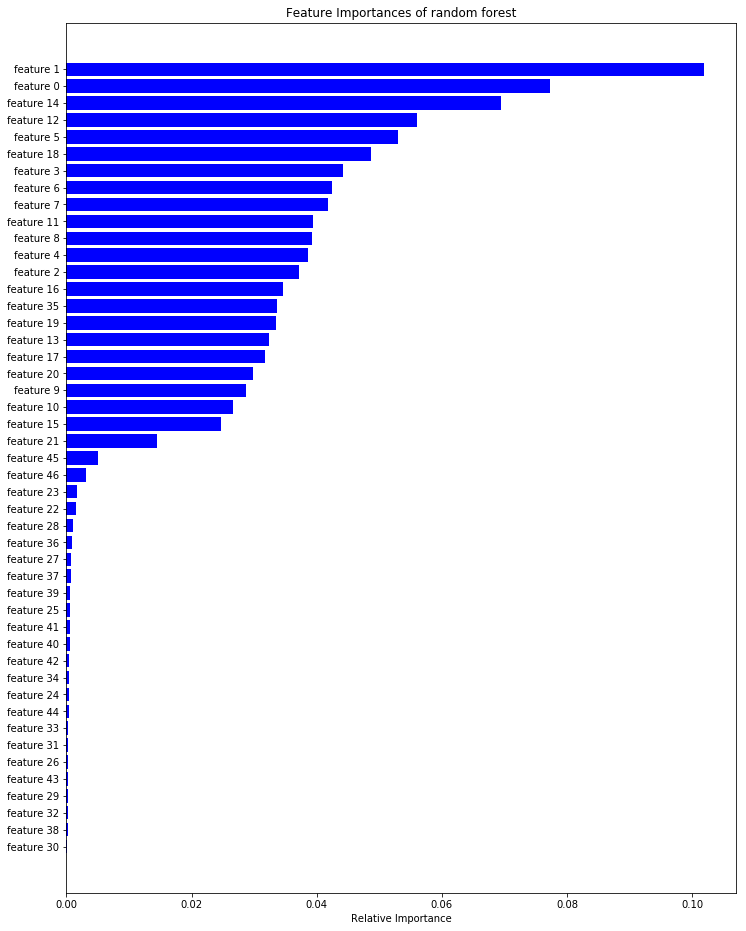

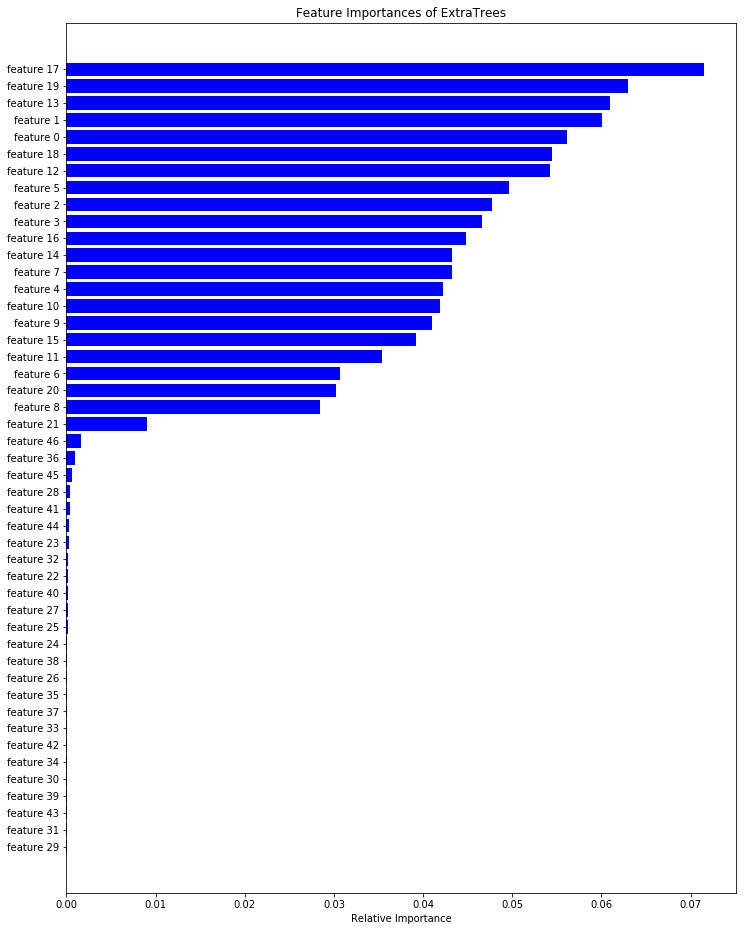

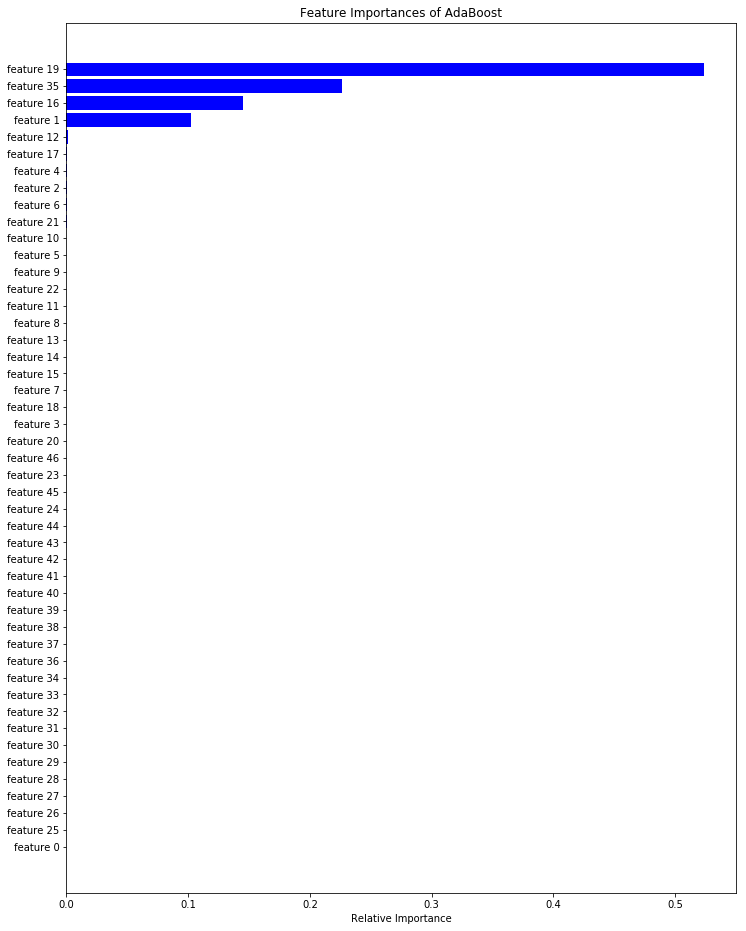

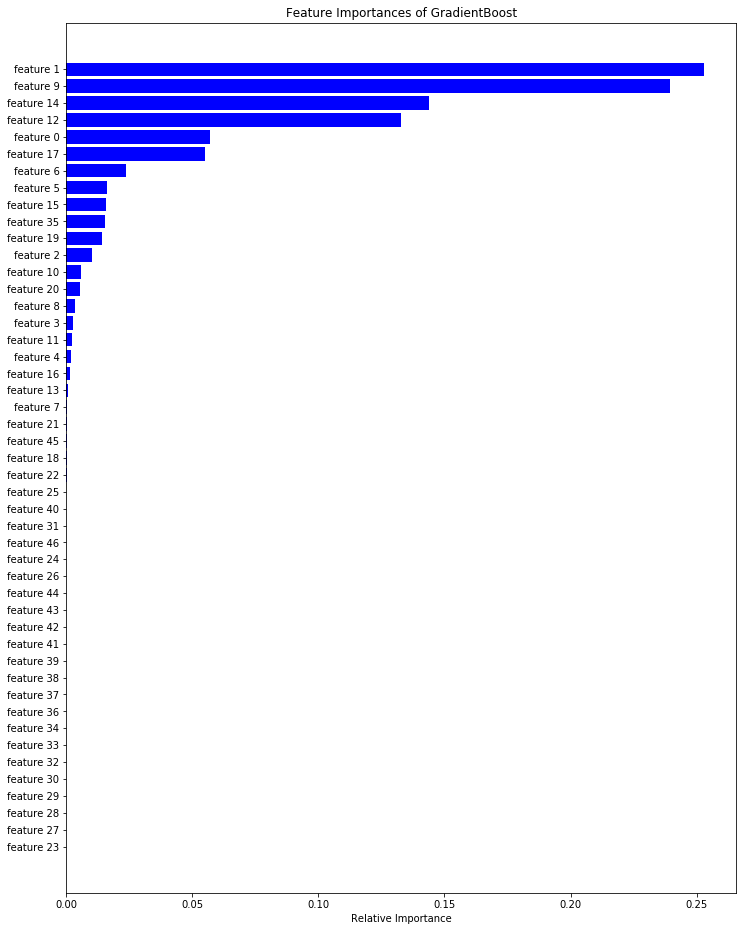

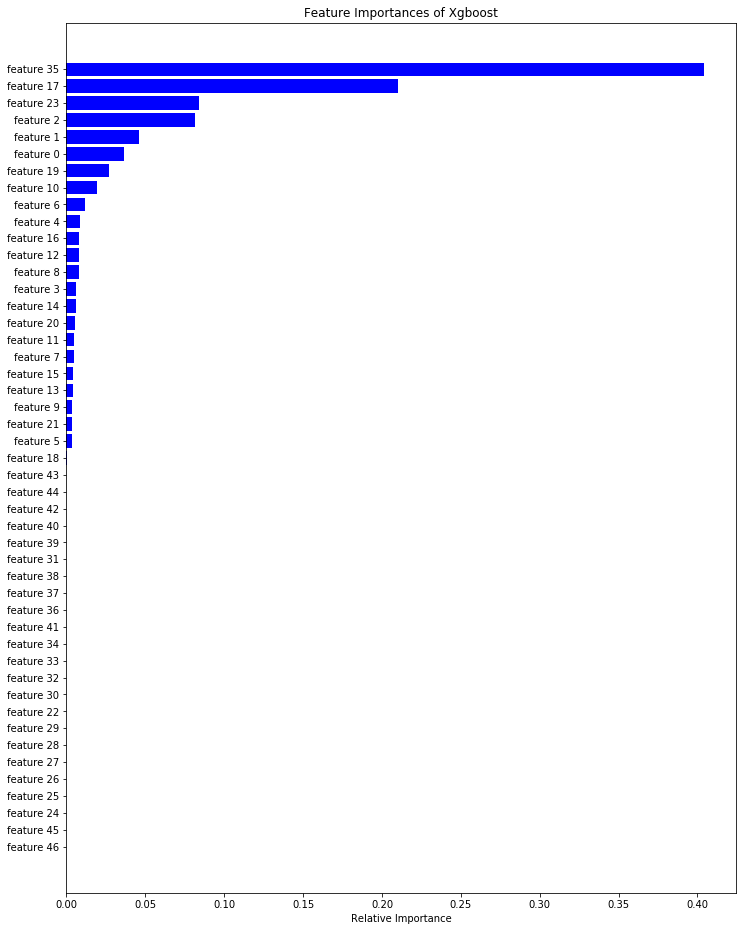

In [152]:
importance=best_rf_reg.feature_importances_
indices = np.argsort(importance)
features= ["feature "+str(i) for i in range(47)]

import matplotlib.pyplot as plt

for idx, m_ in enumerate(models):
    importance=m_.feature_importances_
    indices = np.argsort(importance)
    features= ["feature "+str(i) for i in range(47)]
    plt.figure(figsize=(12,16))
    plt.title('Feature Importances of '+ model_names[idx])
    plt.barh(range(len(indices)), importance[indices], color='b', align='center')
    plt.yticks(np.arange(47),labels=[features[i] for i in indices])
    plt.xlabel('Relative Importance')

Text(0.5, 0, 'Relative Importance')

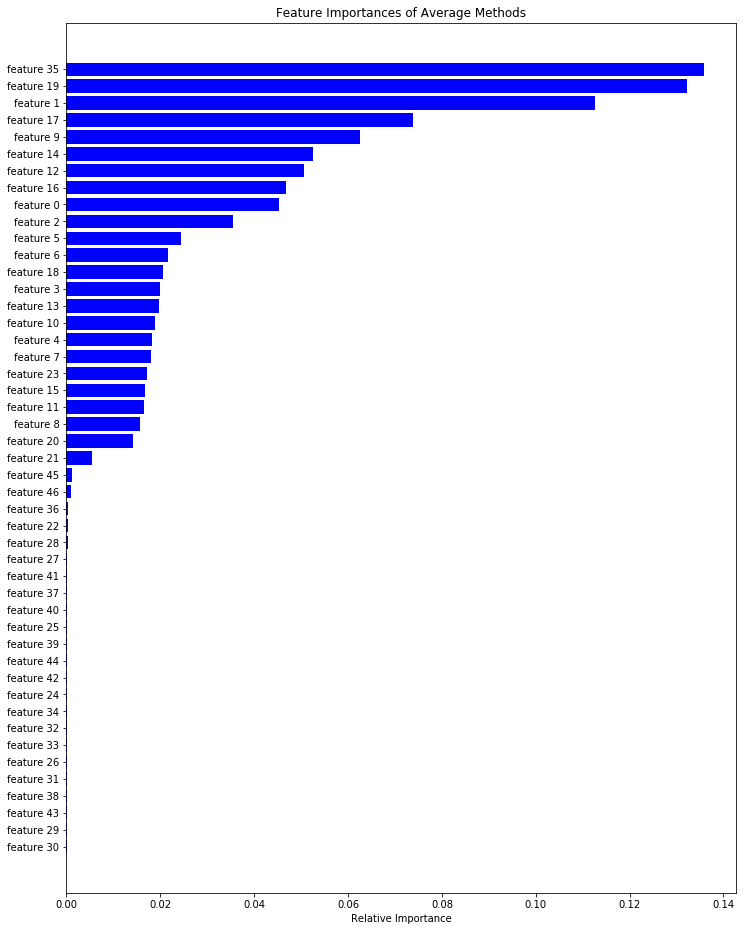

In [153]:
importance=importances.mean(axis=1)
indices = np.argsort(importance)
features= ["feature "+str(i) for i in range(47)]
plt.figure(figsize=(12,16))
plt.title('Feature Importances of Average Methods')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(np.arange(47),labels=[features[i] for i in indices])
plt.xlabel('Relative Importance')

### 2.5 Neural Networks

### 2.6 Dimension Reduction 

## 3. Experimental Results

### 3.1 Data Description and Exploratory Data Analysis




Our dataset in this project includes all listed firms in the NYSE, AMEX, and NASDAQ. Our sample begins in January 2009 to April 2019. Our data is monthly updated. We use the Treasury-bill rate as risk-free rate for calculating the excessive returns. The firms characteristics or the factors in other words, include firms' value, growth, solvency, cash flow, profitability, operating capacity, capital structure and momentum. In addition, we include the categorical industry classes corresponding to GICS sectors.    

### 3.2 Out-of-sample Stock-level Prediction Performance



### 3.3 Variable Importance for factors

### 3.4 Machine Learning Portfolios

## 4. Conclusions

## 5. References

Gu, Shihao, Bryan Kelly, and Dacheng Xiu. *Empirical asset pricing via machine learning.* No. w25398. National Bureau of Economic Research, 2018.

